<h1>Project: Analyze the impact of Covid-19 on the Autralian economy and the unemployment rate </h1>

COMP2200 (2020 S2) - Rachel Ullmann, Ivy Ly (44367767), Raffi Tchamkertenian(46464565), Danny Bui (46042784)

# Project Introduction

The outbreak of Covid-19 in early January 2020 has proven to be only not a national health crisis but also a severe economic crisis with the June quarter seeing the Australian economy plunge into its first recession in over 30 years. The recession, driven by the mandatory lockdown of businesses and households to limit the spread of Covid-19, will require significant intervention by the government and reserve bank of Australian (RBA) to overcome. Broadly, there are two measures which can be used stimulate an economy. The first is fiscal policy which entails government expenditure in capacities such as direct cash transfer payments, tax cuts, infratructure projects, guaranteed jobs etc. The second, which will be the focus of this project, is monetary policy. This entails the RBA adjusting the monthly cash rate (national interest rate) to incentivise investment and spending.

# Project aims

The aim of our project is to first analyze the impact of Covid-19 on the Australian economy. Here, we will explore how the various states and territories, industries and genders have been affected. Second, we seek to model the Australian unemployment rate and Australian recessions. More specifically, the former will be our baseline linear regression model which will be used to predict the unemployment rate. And, the latter will be used to classify which calendar quarter will see the Australian economy fall into a recession. Finally, our project will seek to answer how the RBA ought to respond in order to stimulate the economy and drive down the unemployment rate.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from datetime import timedelta
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
sns.set()
plt.style.use('seaborn')
%matplotlib inline

# Datasets

In [2]:
# Covid-19 exploration datasets
covid_df = pd.read_excel('Data sets/Monthly Covid-19 cases.xlsx')
arrivals_df = pd.read_excel('Data sets/Monthly International arrivals by state of clearance.xlsx')
cash_rate_df = pd.read_excel('Data sets/Monthly RBA cash rate.xlsx')
unemployment_df = pd.read_excel('Data sets/Monthly Unemployment rate.xlsx')
job_vacancies_df = pd.read_excel('Data sets/Monthly job vacancies.xlsx')
state_unemployment_df = pd.read_excel('Data sets/Monthly Unemployment rate (state).xlsx')

# Unemployment rate model datasets
investment_df = pd.read_excel ('Data sets/Quarterly capital investment.xlsx',index_col='Date', parse_dates=True)
GDP_df = pd.read_excel('Data sets/Quarterly GDP.xlsx',index_col='Date', parse_dates=True)
inflation_df = pd.read_excel ('Data sets/Quarterly Inflation.xlsx',index_col='Date', parse_dates=True)
hoursworked_df = pd.read_excel ('Data sets/Quarterly hour worked danny.xls',index_col='Date', parse_dates=True)
balancepayments_df = pd.read_excel ('Data sets/Monthly balance of goods and services.xlsx',index_col='Date', parse_dates=True)

## Data Set Descriptions

**The data sources used in this project were (all in xls format):**
- covid_df - Number of Monthly Covid-19 Cases at National and state level from Jan 2020 to Aug 2020 which is available at National Notifiable Diseases Surveillance System - Department of Health (http://www9.health.gov.au/cda/source/rpt_1.cfm).
- arrivals_df - The number of monthly international arrivals to Australia by country of residence from Jul 1975 to Jul 2020, retrieved from ABS - Visitor arrivals and resident returns by country(https://www.abs.gov.au/statistics/industry/tourism-and-transport/overseas-travel-statistics-provisional/aug-2020#data-download).
- cash_rate_df - Monthly RBA Cash Rate from Jan 1990 to August 2020 from the Reserve Bank of Australia. (https://www.rba.gov.au/statistics/cash-rate/)
- unemployment_df - Monthly Unemployment Data in Australia (https://www.abs.gov.au/statistics/economy/key-indicators)
- job_vacancies_df - Job Vacancies dataset contained the number of monthly job vacancies in Australia by state from Nov 1993 to May 2020 , retrieved from Vacancy Report from Australian Government - Labour Market Information Portal (https://lmip.gov.au/default.aspx?LMIP/GainInsights/VacancyReport).
- investment_df - Quarterly Capital Investment in Australia (https://www.abs.gov.au/statistics/economy/business-indicators).
- GDP_df - Quarterly Gross Domestic Product (GDP) in Australia (https://www.rba.gov.au/statistics/tables/).
- inflation_df - Quarterly Inflation in Australia (https://www.rba.gov.au/statistics/tables/).
- hoursworked_df - Quarterly Hours worked in Australia (https://www.abs.gov.au/statistics/labour/earnings-and-work-hours).
- balancepayments_df - Monthly Balance of Goods and Services (BOGS) which records the value of exported goods and services and the value of imported goods and services (https://www.abs.gov.au/statistics/economy/international-trade/international-trade-goods-and-services-australia/sep-2020).
- state_unemployment_df - Unemployment rate by state (https://lmip.gov.au/default.aspx?LMIP/LFR_SAFOUR/LFR_UnemploymentRate).

# Data cleaning

#### Formatting and setting date index and dropping N/A rows

In [3]:
# Function to set date index to month-year format
def setDateIndexMonthYear(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime("%b-%Y")
    df.set_index('Date', inplace= True )
    df.dropna(inplace = True)
    return df

# Month-year format set to index for covid dataset
covidDatasets = [covid_df, arrivals_df, cash_rate_df, unemployment_df, job_vacancies_df, state_unemployment_df]
for df in covidDatasets:
    setDateIndexMonthYear(df)

In [4]:
# Function to set date index to quarter-year format
def SetDateIndexQuarter(df):
    df.index = pd.to_datetime(df.index)
    df['Date quarter'] = pd.PeriodIndex(df.index, freq='Q')
    df.set_index('Date quarter', inplace = True)
    df.dropna(inplace = True)
    return df
# Quarter-year format set to index for unemployment rate model dataset
unemploymentModelDatasets = [investment_df, GDP_df, inflation_df, hoursworked_df, balancepayments_df]
for df in unemploymentModelDatasets:
    SetDateIndexQuarter(df)

#### Change column name

In [5]:
hoursworked_df.columns = ['Hours Worked']

#### Create new colum

In [6]:
# Create new column for investment df with total investment 
investment_df["total investment"] = investment_df.sum(axis=1)

#### Remove columns

In [7]:
investment_df.drop(investment_df.columns[0:3], inplace = True, axis =1)
unemployment_df.drop(unemployment_df.columns[0:54], inplace = True, axis =1)
unemployment_df.drop(unemployment_df.columns[27:], inplace = True, axis =1)
GDP_df.drop(GDP_df.columns[0], inplace = True, axis =1)
GDP_df.drop(GDP_df.columns[1:], inplace = True, axis =1)

# Data exploration

### States most affect by Covid

In [8]:
# Create new covid df
heat_covid_df = covid_df.copy()
heat_covid_df.drop(columns='AUS', inplace=True)
heat_covid_df = heat_covid_df[['ACT','NT','TAS','SA','WA','QLD','NSW','VIC']]
heat_covid_df = heat_covid_df.reindex(index=heat_covid_df.index[::-1])

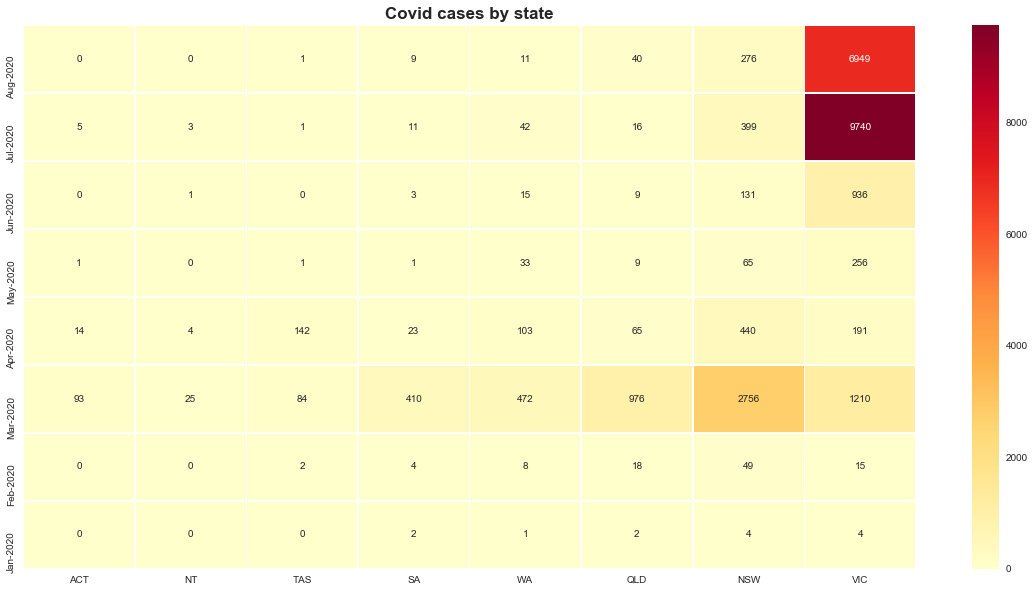

In [9]:
# Plot heatmap 
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(heat_covid_df, cmap="YlOrRd", linewidths=.5, annot=True, fmt='g')
plt.title('Covid cases by state', fontsize=17,weight='bold')
ax.set_ylabel('') 
plt.show()

In [10]:
heat_covid_df

,ACT,NT,TAS,SA,WA,QLD,NSW,VIC
Date,,,,,,,,
Aug-2020,0,0,1,9,11,40,276,6949
Jul-2020,5,3,1,11,42,16,399,9740
Jun-2020,0,1,0,3,15,9,131,936
May-2020,1,0,1,1,33,9,65,256
Apr-2020,14,4,142,23,103,65,440,191
Mar-2020,93,25,84,410,472,976,2756,1210
Feb-2020,0,0,2,4,8,18,49,15
Jan-2020,0,0,0,2,1,2,4,4


The heatmap shows the number of monthly confirmed cases across the states and territories since the outbreak of Covid-19 in January 2020.

With the exception of Victoria the total number of  confirmed Covid-19 cases across the states and territories peak in May 2020 before gradually declining. Victoria is the clearly the outlier and the most affected state with the total and peak number of confirmed cases far exceeding the rest of the country.

### Impact of international border restrictions

#### Australian international arrivals

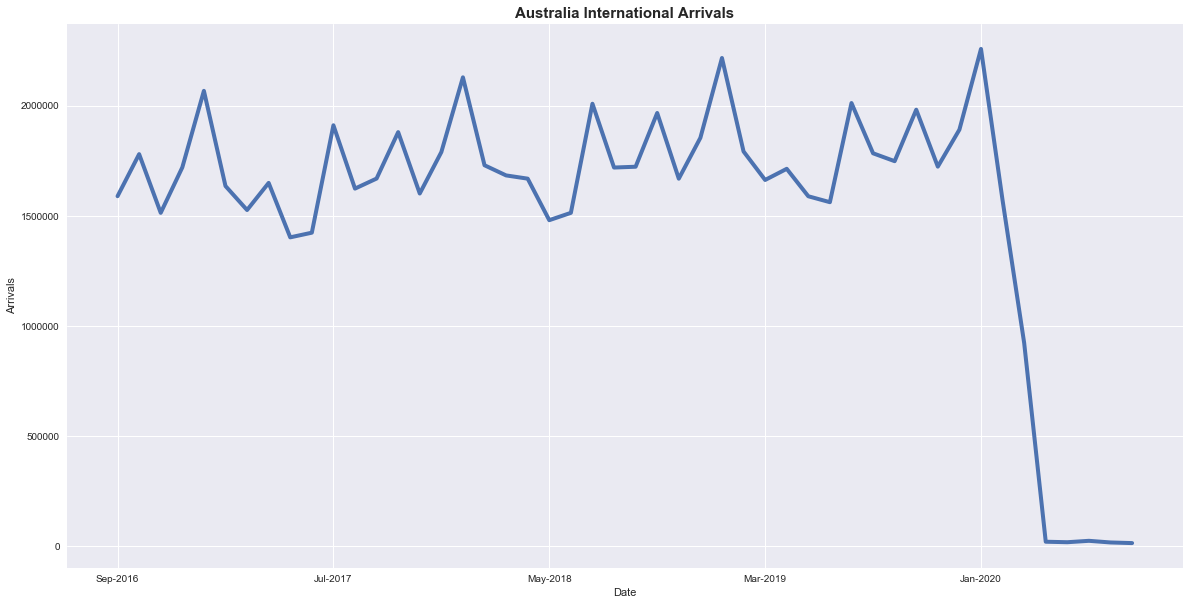

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylabel('Arrivals')
ax.set_xlabel('Date')
plt.title('Australia International Arrivals', fontsize=15,weight='bold')
arrivals_df.Australia.plot(linewidth=4, color='b')
plt.show()

This line graph shows the total international arrivals into Australia from September 2016 until August 2020. We can observe a slight positive seasonality trend with peaks during the December months with a sudden drop to near 0 in January 2020.

#### International arrivals by state and national Covid-19 cases

In [12]:
#merge arrivals and covid df into new
arrivals_covid= pd.merge(arrivals_df, covid_df, how = 'outer' , on='Date' )
arrivals_covid.index = pd.to_datetime(arrivals_covid.index)
arrivals_covid.drop('Australia', axis=1, inplace=True)

In [13]:
arrivals_covid

,New South Wales,Victoria,Queensland,South Australia,Western Australia,Tasmania,Northern Territory,ACT_x,ACT_y,NSW,NT,QLD,SA,TAS,VIC,WA,AUS
Date,,,,,,,,,,,,,,,,,
2016-09-01,611700,405310,320720,42480,191100,0,17370,1480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-01,706420,441150,344250,47330,216040,10,21970,3910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01,609170,388780,283230,35850,175590,80,18250,3660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01,690540,446980,326470,42640,195490,4420,11650,2720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,844600,528230,369900,52310,245060,1310,22240,4690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01,670180,427090,287080,38560,189240,7540,13280,3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01,616060,394760,291430,35160,168140,4750,13390,3690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-01,668710,420180,315970,35210,189970,1900,14500,4010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-01,567850,355720,270600,33850,157610,0,14730,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


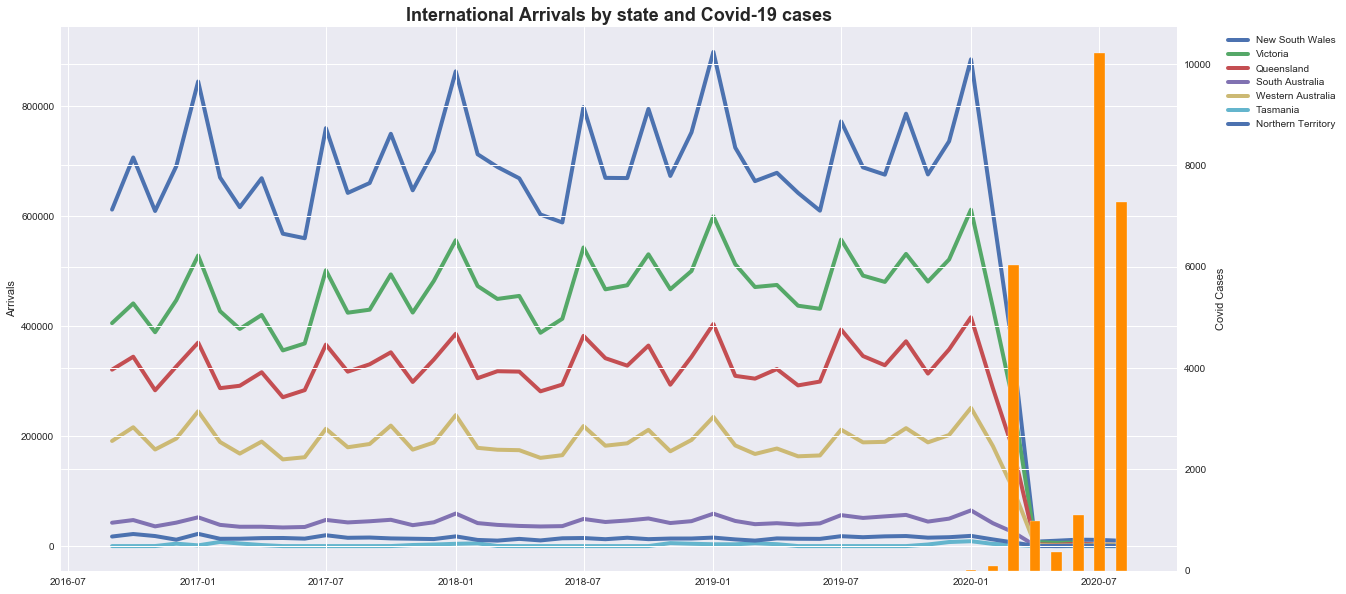

In [14]:
#set graph size, x and y axis
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylabel('Arrivals')
ax.plot(arrivals_covid[['New South Wales', 'Victoria','Queensland', 'South Australia', 'Western Australia','Tasmania', 'Northern Territory']].loc['Sep-2016':],linewidth=4, zorder=0)
ax.legend(['New South Wales', 'Victoria','Queensland', 'South Australia', 'Western Australia','Tasmania','Northern Territory'], bbox_to_anchor=(1.15, 1))
plt.title('International Arrivals by state and Covid-19 cases', fontsize=18,weight='bold')
#plot arrivals by state from Sep 2016
ax2 = ax.twinx()
ax2.tick_params(axis='y')
ax2.set_ylabel('Covid Cases')
ax2.bar(arrivals_covid.index, arrivals_covid['AUS'], width=15, color= 'darkorange', zorder=10)
plt.show()

This plot breaks down international arrivals by state as well as the monthly number of covid cases. Prior to the outbreak of Covid-19 in January 2020, we can see a stable trend for all states, with peaks occuring over the holidays months particularly at the end of year. As the number of Covid-19 cases rise over February and March 2020 the number of international arrivals drop significantly , even before the announcement of travel restrictions and bans. After the international travel ban was announced in late March, which imposed limits on the  number of international arrivals per month, we can that arrivals across the states remain flat. Hence we can observe that Covid has had a significant impact on the international arrivals into Australia for each state. This strong relationship shows that NSW, Victoria, Queensland and Western Australia has been affected the most since these states have always had a large number of international arrivals in the past.

#### Relationship between international arrivals and unemployment rate

In [15]:
##merge cash rate df and unemployment within states
unemploy_df=unemployment_df[['Unemployment rate NSW','Unemployment rate Victoria','Unemployment rate Queensland','Unemployment rate South Australia','Unemployment rate Western Australia','Unemployment rate Tasmania','Unemployment rate Northern Territory','Unemployment rate Australian capital territory']]
cashrate_unemployment = pd.merge(unemploy_df, cash_rate_df, how = 'outer' , on='Date' )
cashrate_unemploy=cashrate_unemployment.dropna()
##change column headings
cashrate_unemploy.columns=['NSW','VIC','Queensland','SA','WA','TAS','NT','ACT','Cash Rate']
cashrate_unemploy.head()

,NSW,VIC,Queensland,SA,WA,TAS,NT,ACT,Cash Rate
Date,,,,,,,,,
Aug-1990,6.408647,6.260645,8.094810,8.089377,7.648001,9.160017,7.104974,4.697818,14.000000
Sep-1990,6.807682,6.820065,7.967979,8.433300,8.300904,9.291520,8.547961,4.391836,14.000000
Oct-1990,6.240983,6.981338,8.039421,8.044538,7.909861,9.175585,8.096814,5.446667,13.434783
Nov-1990,6.616639,7.570022,8.195478,7.984178,8.056036,8.369886,5.959111,5.364709,13.000000
Dec-1990,7.250639,8.057391,9.464339,8.467505,8.684312,9.757299,8.475089,6.212511,12.578947


In [16]:
unemploy_aus=unemployment_df[['Unemployment rate Australia']]
cashrate_unemploy_aus = pd.merge(unemploy_aus, cash_rate_df, how = 'outer' , on='Date' )
cashrate_unemploy_aus = cashrate_unemploy_aus.dropna()
arrivals_aus=arrivals_df[['Australia']]
cashrate_unemploy_arrivals = pd.merge(cashrate_unemploy_aus, arrivals_aus, how = 'outer' , on='Date' )
job_aus=job_vacancies_df[['AUST']]
pp_df = pd.merge(job_aus, cashrate_unemploy_arrivals, how = 'outer' , on='Date' )
##covid_aus=covid_df[['AUS']]
##pairplot_df = pd.merge(pp_df, covid_aus, how = 'outer' , on='Date' )
pp_df.columns=['Job Vacancies','Unemployment Rate','Cash Rate','Arrivals']
pp_df=pp_df.dropna()
pp_df.drop('Cash Rate', axis=1, inplace=True)
##pairplot_df=pairplot_df[['Job Vacancies','Unemployment Rate','Cash Rate','Arrivals']]

AttributeError: module 'seaborn' has no attribute 'histplot'

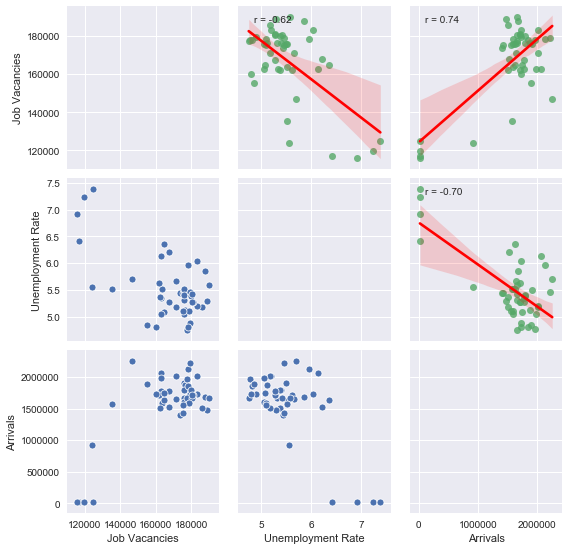

In [17]:
combined_pp=sns.PairGrid(pp_df)
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)    
    
combined_pp.map_upper(corrfunc)
combined_pp.map_upper(sns.regplot, color='g', line_kws={"color": "red"})
combined_pp.map_lower(sns.scatterplot)
combined_pp.map_diag(sns.histplot, color=".3")
for ax, col in zip(np.diag(combined_pp.axes), pp_df.columns):
    ax.set_title(col, y=0.82, fontsize=20)

This pairplot shows the relationship between 3 different variables - Job vacancies, unemployment rate, and arrivals. We would like to see if there are any relationships between the unemployment rate, job vacancies as well as international arrivals.
We can see there is a strong positive relationship between job vacancies and arrivals. This may be due to the increase number of job opportunities avaiable due to more people arriving into Australia, which boosts up the economy. There is also a strong negative correlation between job vancancies & unemployment as well as arrivals and unemployment in Australia, since the higher the number of international arrivals (tourists), the higher the job vacancies, hence the lower rate in unemployment. Based on these relationships, we will build a simple linear regression model for further analysis and prediction between the variables and the effectiveness of monetary policy.

### Impact of covid-19 on job vacancies by state and industry

#### Job vacancies by state during covid

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_ylabel('Job Vacancies')
ax.plot(job_vacancies_df[['NSW','VIC','QLD','SA','WA','TAS','NT','ACT']].loc['Jan-2020':],linewidth=4, zorder = 2)
ax.legend(['NSW','VIC','QLD','SA','WA','TAS','NT','ACT'], bbox_to_anchor=(1, 1))
plt.title('Job vacancies across states 2020', fontsize=18,weight='bold')
plt.show()

To see the changes in job vacancies across the states since the outbreak of Covid-19 in Australia, we have built a multiple-line chart as above. From the line chart, NSW and VIC job vacancies have been fluctuating while the remaining states are quite stable. An explanation for this difference could be that NSW and VIC were the two states with the highest confirmed cases of Covid-19 and that there economies are more reliant on international factors such as tourism (international arrivals).

#### National Job vancancies 2019-2020 

In [ ]:
Covid_JobVacancies = pd.merge(job_vacancies_df, covid_df, how = 'outer' , on='Date' )

In [ ]:
Covid_JobVacancies.index = pd.to_datetime(Covid_JobVacancies.index)
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_ylabel('Job Vacancies')

ax.plot(Covid_JobVacancies['AUST'].loc['Jan-2019':],linewidth=4, zorder = 2)
ax.legend(['Australian total'], bbox_to_anchor=(1, 1))
plt.ylim(0)
ax2 = ax.twinx()

ax2.set_xlabel('Date')
ax2.bar(Covid_JobVacancies.index, Covid_JobVacancies['AUS'], width=15, color= 'darkorange', zorder = 1)
ax2.set_ylabel('Covid Cases')
plt.title('Australian job vancanies 2019 - 2020', fontsize=18,weight='bold')
plt.ylim(0)
plt.show()

The combined line-bar chart demonstrates the whole picture regarding the impacts of covid-19 on job vacancies in the country in overall. We can see job vacancies had reduced significantly since Covid19 began in early 2020, after that 4 months, from May to July the stat has slightly increased while July experiencing the peak of covid19 cases. 

#### Impact of Covid-19 on job vacancies by industry

In [ ]:
Covid_JobVacancies.index = pd.to_datetime(Covid_JobVacancies.index)
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_ylabel('Job Vacancies')
ax2.set_ylabel('Covid Cases')

ax.plot(Covid_JobVacancies[['Agriculture Total', 'Corporate Professionals Total',
       'Health Total', 'Hospitality and Retail Total', 'ICT Total',
       'Office Clerks Total', 'Other Total']].loc['Jan-2019':],linewidth=4, zorder = 2)

ax.legend(['Agriculture Total', 'Corporate Professionals Total',
       'Health Total', 'Hospitality and Retail Total', 'ICT Total',
       'Office Clerks Total', 'Other Total'], bbox_to_anchor=(1.2, 1))

ax2 = ax.twinx()

ax2.set_xlabel('Date')
ax2.bar(Covid_JobVacancies.index, Covid_JobVacancies['AUS'], width=15, color= 'darkorange', zorder = 1)
ax2.set_ylabel('Covid Cases')
plt.ylim(0)

plt.title('Job vacancies by industry 2019 - 2020', fontsize=18,weight='bold')
plt.show()

The plot shows job vacancies from 2019 onwards by industry. We can see that corporate, office clerks and hospitality  and retail industries are trending downwards from the second half of 2019 however the outbreak of Covid-19 significantly exacerbated the job losses in those industries. Agriculture and health industries on the otherhand experienced some gains in job vancancies during Covid-19 which is likely the result of ensuring food and health security for the country. Job vacancies across all industries begin to stabilise around May 2020 as lockdown restrictions begin to ease and goverment stimulus flows into the economy.

### Covid-19, unemployment rate and monetary policy

#### Unemployment rate by state 19-20

In [ ]:
heat_state_employment_df = state_unemployment_df.loc['Jan-2019':].copy()
heat_state_employment_df = heat_state_employment_df.reindex(index =heat_state_employment_df.index[::-1])
# PLot heat map
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(heat_state_employment_df, linewidth = 5, annot = True, fmt = 'g', cmap = 'coolwarm')
plt.title("Unemployment rate by state 19-20", fontsize = 17, weight = 'bold')
ax.set_ylabel('')
plt.show()

The heatmap shows the the unemployment rate by state from 2019 onwards. It can be seen that from April 2020 all states and territories begin experience to deterioriations in the unemployment with the highest rates occuring in QLD, SA and WA. The ACT on the otherhand was least affected state.The northern territory (NT) is the only state to have recovered from the impact of Covid with unemployment rate returning to a low of 4.2% in August. While, NSW and VIC suffered the largest changes in unemployment going from 4% and 4.6% to a peak of 7.2% and 7.5% respectively. 

#### Distribution of unemployment rates by state  and gender during covid

In [ ]:
# Create new unemployment df with unemployment data during Covid
distribution_unemployment_df = unemployment_df.copy()
distribution_unemployment_df = distribution_unemployment_df.loc['Jan-2020':]
# Plot boxplot
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data = distribution_unemployment_df)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.legend(['State - total', 'State - males', 'State - females'])
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('r')
leg.legendHandles[1].set_color('g')
leg.legendHandles[2].set_color('b')
# Colours boxplot by group (total, males and females)
i = 0
colour = 0
for x in range(3):
    colour = colour + 1
    for x in range(9):
        mybox = ax.artists[i]
        if colour == 1:
            mybox.set_facecolor('r')
        elif colour == 2:
            mybox.set_facecolor('g')
        elif colour == 3:
            mybox.set_facecolor('b')
        i = i + 1
plt.title('Boxplot of unemployment rate by state and gender during Covid-19', fontsize=18,weight='bold')
plt.show()

The boxplot shows the distribution/spread of the unemployment rate across the states and territories and across gender during the Covid-19 pandemic.

The median total unemployment rate is highest in South Austrlia and Queensland but is not significantly greater than the rest of the country with the exception of the Australian capital territory which has a significantly lower median. 

The affect of Covid-19 on unemployment has not disporportionately affected either gender excluding a couple of notable differences. The first is that the median unemployment rate for males in Queensland and South Australia is relatively higher compared to females. The second is that the spread of unemployment for males in the ACT is much larger compared to females. 

#### National unemployment rate and monetary policy response to covid-19

In [ ]:
# Merge covid and unemployment into new df
Covid_unemployment = pd.merge(unemployment_df, covid_df, how = 'outer' , on='Date' )
Covid_unemployment.index = pd.to_datetime(Covid_unemployment.index)
# Plot unemployment rate from Jan-15 onwwards
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(Covid_unemployment['Unemployment rate Australia'].loc['Jan-2015':], color= 'b',linewidth=4, zorder=1)
plt.title('Monetary policy, unemployment rate & Covid-19 cases', fontsize=17,weight='bold')
# plot cash rate
ax.plot(Covid_unemployment['Unemployment rate Australia'].loc['Jan-2015':].index,cash_rate_df['Cash Rate Target'].loc['Jan-2015':], color= 'g',linewidth=4, zorder=0)
# set unemployment axis range
ax.set_ylabel('Unemployment rate & cash rate')
ax.legend(['Unemployment rate', 'Cash rate'])
plt.ylim(0, 8)
# set Covid axis
ax2 = ax.twinx()
ax2.set_ylabel('Covid Cases')
# Plot Covid cases from Jan-18 onwards
ax2.bar(Covid_unemployment.index, Covid_unemployment['AUS'], width=17, color= 'r',zorder=100)
# set Covid axis range
ax2.tick_params(axis='y')
plt.ylim(0, 12000)
plt.show()

From 2015 until the outbreak of Covid-19 in January 2020 the unemployment rate displays two principal trends. The first is that the unemployment rate is largely trending downwards, going from a peak of about 6.75% in 2015 to approximately 4.75% in the second half of 2019. The second trend is that from year to year the unemployment rate follows an annual cycle whereby it falls from a peak at the beginning, reaches a valley in the middle before peaking again at a lower point at the start of the following year. This trend highly suggests that the unemployment rate during this period follows a typical business cycle.

From 2020 onwards however unemployment sharply rises as Covid-19 begins to spread within the country with the height of  unemployment coinciding with the peak of confirmed Covid-19 cases around the middle of the year. In response to the economic fall out induced by Covid-19 the RBA has lowered the cash rate to near 0% in the the hopes stimulating the economy and alleviating unemployment rate.  

#### Effectiveness of monetary policy

In [ ]:
monetary_policy_df = pd.merge(unemployment_df, cash_rate_df, on = 'Date', how = 'inner')
monetary_policy_df.dropna(inplace = True)
corr, _ = pearsonr(monetary_policy_df['Cash Rate Target'], monetary_policy_df['Unemployment rate Australia'])
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.scatterplot(x=monetary_policy_df['Cash Rate Target'], y=monetary_policy_df['Unemployment rate Australia'])
g.text(11, 11.5, 'Correlation coefficient: %.3f' % corr , horizontalalignment='left', size='large', weight='semibold')
plt.title('Relationship between unemployment rate and cash rate', fontsize=17,weight='bold')
plt.show()

The scatterplot does not reflect a particularly strong relationship between the national unemployment rate and the cash rate from 1990 onwards as shown by the correlation coefficient of 0.395. Furthermore, a positive correlation is quite unexpected given that we would expect there to be an inverse relationship. That is, we expect that as unemployment rises the cash rate would fall so as to stimulate economy.

The absence of a strong relationship suggests that monetary policy, the adjustment of the cash rate, alone is not particularly effective in influencing the unemployment rate. One explanation could be that the reserve bank of Australia is considering other economic factors such as inflation when implementing monetary policy.

# Data modelling

## Baseline linear regression model - Australian unemployment

In [ ]:
# Group cash rate df by quarter and mean
quarterly_cash_rate_df = cash_rate_df.copy()
SetDateIndexQuarter(quarterly_cash_rate_df)
quarterly_cash_rate_df = quarterly_cash_rate_df.groupby("Date quarter").mean()
# Group cash rate df by quarter and mean
quarterly_unemployment_df = unemployment_df.copy()
SetDateIndexQuarter(quarterly_unemployment_df)
quarterly_unemployment_df = quarterly_unemployment_df.groupby("Date quarter").mean()

In [ ]:
# Create unemployment rate model dataset 
unemploymentModelDatasets = [investment_df,GDP_df, inflation_df, hoursworked_df, balancepayments_df,quarterly_cash_rate_df]
unemployment_rate_model_dataset = quarterly_unemployment_df.copy()
# Only retaining national unemployment rate
unemployment_rate_model_dataset.drop(unemployment_rate_model_dataset.columns[1:], inplace = True, axis = 1)
# Merge all the datasets
for df in unemploymentModelDatasets:
    unemployment_rate_model_dataset = pd.merge(unemployment_rate_model_dataset,df, on ='Date quarter', how = 'inner' )
unemployment_rate_model_dataset = unemployment_rate_model_dataset.groupby('Date quarter').mean()
# Add column with recession
Recession = []
i = 0
for row in unemployment_rate_model_dataset.index:
    if unemployment_rate_model_dataset['Year-ended real GDP growth'].iloc[i] < 0:
        Recession.append('Y')
    else:
        Recession.append('N')
    i = i +1
unemployment_rate_model_dataset["Recession"] = Recession
# Initialise label encoder
le = LabelEncoder()
le.fit(list(unemployment_rate_model_dataset["Recession"].values))
# new genre column with encoding labels
unemployment_rate_model_dataset["Recession"] = le.transform(list(unemployment_rate_model_dataset["Recession"]))
# inverse transform
Recession_names  = list(le.inverse_transform([0,1]))
unemployment_rate_model_dataset

#### Split unemployment rate model dataset

In [ ]:
X = unemployment_rate_model_dataset.drop(columns = ['Unemployment rate Australia', 'Recession'])
y = unemployment_rate_model_dataset["Unemployment rate Australia"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

#### Linear regression model

In [ ]:
# Instantiate linear regression model
linear_model = LinearRegression()
# Train linear model
linear_model.fit(X_train, y_train)

#### Predict and evaluate linear regression model

In [ ]:
# Prediction for baseline model test set
y_hat_test_linear = linear_model.predict(X_test)
# Assess model
MSE_linear = mean_squared_error(y_test, y_hat_test_linear)
R2_linear = r2_score(y_test, y_hat_test_linear)
MAE_linear = mean_absolute_error(y_test, y_hat_test_linear)
print("MSE ",MSE_linear )
print("R2: ", R2_linear)
print("MAE: ", MAE_linear)

The linear regression model performed quite well given the evaluation metrics.

#### Feature importance using RFE

In [ ]:
from sklearn.feature_selection import RFE
estimator = LinearRegression()
rmse_scores = []
for i in range(1,7):
    selector = RFE(linear_model, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, y_train)
    y_hat_test = selector.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_hat_test))
    print("RMSE score on test set using", i, "features: ", rmse_test)
    rmse_scores.append(rmse_test)

In [ ]:
## Feature selection by selecting 3
rfe = RFE(linear_model, n_features_to_select=3)
rfe = rfe.fit(X_train, y_train)
# print summaries for the selection of attributes
print(rfe.support_)
print(rfe.ranking_)
print('Optimal number of features :', rfe.n_features_)
print('Best features :', X_train.columns[rfe.support_])

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()   
plt.xlabel('No. of features selected')
plt.ylabel('RMSE on the test set')
plt.title('RMSE score on test set using RFE', fontsize=18, fontweight='bold')
plt.plot(range(1, 7), rmse_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'DarkBlue', markerfacecolor = 'None')
plt.show()

RFE is used to select features on RMSE score on the test set. We have also tested using 3 features. We then use cross-validation to see what it gives for the optimal number of features.

In [ ]:
# RFECV to find optimal number of features
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
model = LinearRegression()
k =KFold(n_splits=4, random_state=42, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=k, scoring='neg_mean_squared_error')
rfecv = rfecv.fit(X_train, y_train)

In [ ]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

In [ ]:
# Plot number of features VS. cross-validation scores RMSE
plt.figure(figsize=(20,10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation Score: RMSE")
plt.title('RMSE scores on test set using RFECV', fontsize=18, fontweight='bold')

rmse_cv_scores = np.sqrt(-rfecv.grid_scores_)

p = plt.plot(range(1, len(rfecv.grid_scores_) + 1), rmse_cv_scores, marker='o', color='orange')
plt.grid(alpha=0.5)
plt.show()

We can see that the optimal number of features for our model still remains at 6.

# Further prediction techniques

### The decision tree model handling the regression problem

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Training a regression tree with max_depth=4.
regressor = DecisionTreeRegressor(random_state=42, max_depth=4)
regressor.fit(X_train, y_train)

#### Evaluate the model with the testing data

In [ ]:
y_pred = regressor.predict(X_test)
r2score_dcf = r2_score(y_test,y_pred)

print("\nThe r2 score is: %.4f\n" % r2score_dcf)
mse_test_dcf = mean_squared_error(y_test, y_pred)
mse_train_dcf = mean_squared_error(regressor.predict(X_train), y_train)
print("The mean squared error (testing) is: %.4f\n" % mse_test_dcf)
print("The mean squared error (training) is: %.4f\n" % mse_train_dcf)

mae_dcf = mean_absolute_error(y_test, y_pred)
print("The MAE is : ", mae_dcf)

There is a slight improvement in performance in the Decision Tree Model comparing to the Baseline Linear Model.

In [ ]:
from sklearn import tree
text_representation = tree.export_text(regressor)
print(text_representation)

#### Visualize the tree structure.

Installing graphviz Python libraries to run the cell below. Otherwise, simply skip this cell and move to the next cell to see the result as we have run and generated a corresponding png to render

In [ ]:
#Note: the graphviz Python libraries required to be install to run this code
from sklearn.tree import export_graphviz
export_graphviz(regressor,
                out_file="tree_reg.dot",
                feature_names=X.columns,
                class_names=["UnemploymentRate"],
                rounded=True,
                filled=True
               )
# Convert dot file to png file.
!dot -Tpng tree_reg.dot -o tree_reg.png

In [ ]:
# Render the image 
from IPython.display import Image
Image(filename='Images/tree_reg.png')

### Comparing the performances between linear regressors

In [ ]:
d = {'Model': ['Linear Regression','Decision Tree Regression'],'R2':[R2_linear,r2score_dcf], 'MSE': [MSE_linear,mse_test_dcf], 'MAE': [MAE_linear,mae_dcf]}
compare_regressions = pd.DataFrame(data = d)
compare_regressions

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 10))
tidy = compare_regressions.melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy, ax=ax1)
plt.title('Evaluation of linear regression vs decision tree', fontsize=18, fontweight='bold')
sns.despine(fig)

Overall, both models have good performance with the R2 Scores’ are 0.77 and 0.82 respectively. This means the proportion of the variance in the dependent variable that is predictable from the independent variables. In other words,  unemployment rates and the 6 features that we selected such as ‘Total Investment’, ‘GDP growth’, ‘Inflation’, ‘Hours Worked’, ‘Balance on goods and services’, ‘Cash Rate Target’ are well correlated with the variance of 23% in the baseline model, and of 0.18% in the decision tree model.

# Predicting (classifying) recessions

Recessions are periods in which an economy contracts resulting in rising unemployment and falling GDP. The impact that a recession imposes on an economy often takes years to recover from with many industries often failing to recover at all. These periods are notoriously difficult to predict, however the ability to accurately and consistently antcipate them would mean that goverments, central banks and other financial institutions could prevent or at least mitigate their effects before they can occur. Here, we will attempt model Australian recessions using KNN and ANN and seek to classify whether a calendar quarter will slip into a recession or not.

In [ ]:
# Plot GDP growth rate and unemployment rate from recession_df
Aus_recessions = quarterly_unemployment_df.copy()
Aus_recessions = Aus_recessions.merge(GDP_df, on = 'Date quarter')
Aus_recessions = Aus_recessions.groupby('Date quarter').mean()
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylim(-8, 13)
plt.title('Australian recession since 1985 ', fontsize=17,weight='bold')
ax.plot(Aus_recessions.index.to_timestamp(),Aus_recessions['Unemployment rate Australia'], color= 'b',linewidth=4)
ax.plot(Aus_recessions.index.to_timestamp(),Aus_recessions['Year-ended real GDP growth'], color= 'g',linewidth=4)
plt.gca().legend(('Unemployment rate','GDP growth rate'))
plt.show()

Australia has experienced three recessions since the late 1970's with the first occuring the 1982-83, the second in 1991-92 and finally in 2020. As seen in the graph the unemployment rate and GDP sharply rises and falls respectively during recessions.

## KNN model

#### Split KNN model data

In [ ]:
X = unemployment_rate_model_dataset.drop(columns = 'Recession')
y = unemployment_rate_model_dataset["Recession"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)
print('Training data set shape :' , X_train.shape)
print('Testing data set shape :' , X_test.shape)

#### KNN model tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
parameter_grid = {'n_neighbors': range(1, 86, 5)}
knn_clf = KNeighborsClassifier()
gs_knn = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, random_state = 42, shuffle=True))
gs_knn.fit(X_train, y_train)

print('Best K value: ', gs_knn.best_params_['n_neighbors'])
print('The accuracy: %.4f\n' % gs_knn.best_score_)

#### Instantiate and train KNN model

In [ ]:
# Instantiate and train KNN model
KNN_model = KNeighborsClassifier(n_neighbors = 6)
# Train KNN model
KNN_model.fit(X_train, y_train)

#### Predict and evaluate KNN model

In [ ]:
# Prediction for KNN model test set
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
y_hat_test_KNN = KNN_model.predict(X_test)

#Evaluating
accuracyKNN = accuracy_score(y_test, y_hat_test_KNN)
print("Accuracy score on KNN testing set: ", accuracyKNN)
precisionKNN = precision_score(y_test, y_hat_test_KNN, average='weighted')
print('Testing precision score is: ', precisionKNN)
recallKNN =recall_score(y_test, y_hat_test_KNN, average='weighted')
print('Testing recall score is: ', recallKNN)
bal_scoreKNN = balanced_accuracy_score(y_test, y_hat_test_KNN)
print('Testing balanced accuracy score is: ', bal_scoreKNN)

### Multi-layer Perceptron Classifier

#### Training a basic MLPClassifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
# Training the MLPClassifier with the default parameters (random_state=42)
mlp_model = MLPClassifier(random_state=42)
mlp_model.fit(X_train, y_train)

# Output the accuracy on training data and test data respectively
y_hat_test_mlp = mlp_model.predict(X_test)

#Evaluating
accuracyMLP = accuracy_score(y_test, y_hat_test_mlp)
print("Accuracy score on KNN testing set: ", accuracyMLP)
precisionMLP = precision_score(y_test, y_hat_test_mlp, average='weighted')
print('Testing precision score is: ', precisionMLP)
recallMLP =recall_score(y_test, y_hat_test_mlp, average='weighted')
print('Testing recall score is: ', recallMLP)
bal_scoreMLP = balanced_accuracy_score(y_test, y_hat_test_mlp)
print('Testing balanced accuracy score is: ', bal_scoreMLP)

In [ ]:
# Explore the learned MLP model
print(mlp_model)
print('\n# of layers (including the input layer): %.f\n' % mlp_model.n_layers_)
print('MLP structure: %.f X %.f X %.f\n' % (X.shape[1], mlp_model.get_params()['hidden_layer_sizes'][0], mlp_model.n_outputs_))

#### Use 10-fold cross validation to report a more robust testing performance

In [ ]:
robust_mlp = MLPClassifier(random_state=42)
scores_mlp_default = cross_val_score(robust_mlp, X, y, cv=10, verbose=1)
print('Accuracy range for Multi-layer Perceptron: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores_mlp_default.min(), scores_mlp_default.max(), scores_mlp_default.mean(), scores_mlp_default.std()))

### Comparing the performances between classifiers

In [ ]:
d2 = {'Model': ['KNN','MLP'],'Accuracy':[accuracyKNN, accuracyMLP], 'Precision': [precisionKNN,precisionMLP],
    'Recall': [recallKNN, recallMLP], 'Balance': [bal_scoreKNN,bal_scoreMLP]}
compare_classifiers = pd.DataFrame(data = d2)
compare_classifiers

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 10))
tidy = compare_classifiers.melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy, ax=ax1)
plt.title('Evaluation of KNN classifier vs MLP classifier', fontsize=18, fontweight='bold')
sns.despine(fig)

The plot containing the evaluation metrics for the KNN and MLP model shows that the models are equally effective at classifying recessions as reflected by the accuracy, precision, recall scores. It is worth noting however that these may suffer from undersampling as occurences of recessions are infrequent.

# Categorizing data using K-means clustering

In [ ]:
# import KMeans
from sklearn.cluster import KMeans

In [ ]:
#invest_df= recession_model_df.copy()   original code
invest_df =  unemployment_rate_model_dataset
invest_df.head()

In [ ]:
kmeans5 = KMeans(n_clusters=5)
kmeans5.fit(invest_df)
print(kmeans5)

kmeans5.cluster_centers_

In [ ]:
invest_df['label'] = kmeans5.predict(invest_df)

In [ ]:
_p = sns.lmplot(x="Unemployment rate Australia", y= "Cash Rate Target", data=invest_df, fit_reg=False, hue='label', height=8)

In [ ]:
#show clusters
invest_df[invest_df['label'] == 0].head()

In [ ]:
## Group clusters by mean
invest_df_mean=invest_df.groupby(['label']).agg('mean')
invest_df_mean

Since 5 clusters are used here, it is quite difficult to recognise the similarities between the members of each cluster. The elbow method will be used to find the optimal K-means.

#### Finding optimal K-means using elbow method

In [ ]:
plt.figure(figsize=(20,10))
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(invest_df)
    kmeans.fit(invest_df)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

We can see that the "elbow" shape appears around 2-4 clusters, so lets change the clusters to 3 and fit again.

In [ ]:
kmeans3 = KMeans(n_clusters=3)
kmeans3.fit(invest_df)
print(kmeans3)

kmeans3.cluster_centers_

In [ ]:
invest_df['label'] = kmeans3.predict(invest_df)

In [ ]:
_p = sns.lmplot(x="Unemployment rate Australia", y= "Cash Rate Target", data=invest_df, fit_reg=False, hue='label', height=8)

In [ ]:
plt.figure(figsize=(20,10))
_p = sns.lmplot(x="Inflation", y= "Cash Rate Target", data=invest_df, fit_reg=False, hue='label', height=8)
plt.show()

In [ ]:
invest_df[invest_df['label'] == 0].head()

In [ ]:
## Group clusters by mean
invest_df_mean=invest_df.groupby(['label']).agg('mean')
invest_df_mean

By changing the K means to 3, we have a bit more clearer understanding of each member of the clusters.
Cluster 0 seems to have a high unemployment rate, low investment and high cash rate target. Whereas Cluster 1 has the highest total investment and lowest cash rate target. Cluster 3 seems to have the highest inflation.

### Hierarchical Clustering

In [ ]:
dist = pdist(invest_df, 'euclidean')
linkage_matrix = linkage(dist, method = 'complete')

In [ ]:
plt.figure(figsize=(20,10))
dendrogram(linkage_matrix)
plt.show()

In [ ]:
labels = cut_tree(linkage_matrix, n_clusters=4)
invest_df['label'] = labels
invest_df

In [ ]:
_p = sns.lmplot(x="Unemployment rate Australia", y="Cash Rate Target", data=invest_df, fit_reg=False, hue='label',height=8)

We can see that for our dataframe, either K Means clustering or hierachical clustering can be used to find meaningful groups and members. The advantage of hierachical clustering, is that we do not need to specify the number of clusters beforehand, whereas it was needed for K-means.

# Modelling monetary policy responses to stimluate the economy

#### Historical data 1990Q3 - 2020Q2 

In [ ]:
# Dataframe to vary cash rate
unemployment_rate_responses =  unemployment_rate_model_dataset.loc['2014Q3':].copy()
unemployment_rate_responses.drop(['Unemployment rate Australia','label', 'Recession'], axis = 1, inplace = True)
unemployment_rate_responses.tail()

#### Creating dummy data 2020Q3 - 2022Q4 

In [ ]:
#### Creating dummy future values based off the mean of the prior values - with slight adjustments to better reflect the current movement of the economy considering that the data used ends in August.
data = {'Date quarter': ['2020Q3', '2020Q4', '2021Q1','2021Q2','2021Q3','2021Q4','2022Q1','2022Q2','2022Q3','2022Q4'],
        'total investment':  [55015.0, 57008.5, 56011.75, 56510.125, 56260.9375, 56385.53125, 52315.43121, 50985.23125,47315.43121, 4585.23125], 
        'Year-ended real GDP growth': [-0.00692440, 0.15974227,0.15474227,0.15985497,-0.09024365,0.13201413,0.13206102, 0.13106972, 0.131088675, 0.76534143],
        'Inflation': [0.95, 0.325,0.6375,0.48125,0.559375,0.52031250, 0.42031250,0.36031250,0.32031250,0.26031250],
        'Hours Worked': [5052310, 4952000,4912300,4923100,4913200,4963450,4814250,4712350,4513450,4263450],
        'Balance on goods and services': [7129.1665, 7551.73325,7340.449875,7446.091563,7393.270719,7419.681142, 7524.681142,7119.681142,8215.311142, 8411.685142],
        'Cash Rate Target': [0.25, 0.25,0.25,0.20,0.20,0.10,0.10,0.10,0.10,0.10]
        }
#Defining columns
df = pd.DataFrame (data, columns = ['Date quarter','total investment','Year-ended real GDP growth','Inflation','Hours Worked','Balance on goods and services','Cash Rate Target'])

#reseting index for future data
df = df.set_index('Date quarter')

SetDateIndexQuarter(df)

#### Combining historical and dummy data

In [ ]:
#Adding the data to the other dataset
unemploymentRateResponses = unemployment_rate_responses.append(df)
unemploymentRateResponses.tail()

### Scenario 1 - Expansionary monetary policy only during periods of weak economic growth (GDP growth rate < 1%)

In [ ]:
unemployment_rate_responses_1 =  unemploymentRateResponses.copy()
for row in range(len(unemployment_rate_responses_1)):
    if unemployment_rate_responses_1['Year-ended real GDP growth'].iloc[row] < 1 :
        unemployment_rate_responses_1['Cash Rate Target'].iloc[row] = 0.5
y_hat_test_linear_1 = linear_model.predict(unemployment_rate_responses_1)

Modelling the effect on the unemployment rate when the cash rate is 0.5% during periods of weak economic growth - defined as quarters where GDP growth rate is less than 1%.

### Scenario 2 - Continuous expansionary monetary (zero cash rates all periods) 

In [ ]:
unemployment_rate_responses_2 =  unemploymentRateResponses.copy()
for row in range(len(unemployment_rate_responses_2)):
    unemployment_rate_responses_2['Cash Rate Target'].iloc[row] =  0
y_hat_test_linear_2 = linear_model.predict(unemployment_rate_responses_2)

Modelling the effect on the unemployment rate when the cash rate is 0% for all periods.

### Scenario 3 - Negative cash rates during periods of weak economic growth

In [ ]:
unemployment_rate_responses_3 =  unemploymentRateResponses.copy()
for row in range(len(unemployment_rate_responses_3)):
    if unemployment_rate_responses_3['Year-ended real GDP growth'].iloc[row] < 1 :
        unemployment_rate_responses_3['Cash Rate Target'].iloc[row] = -7.5
y_hat_test_linear_3 = linear_model.predict(unemployment_rate_responses_3)

Modelling the effect on the unemployment rate when the cash rate is -7.5% during periods of weak economic growth. Negative cash rates have not occured in Australia and entails the reserve bank of Australia crediting interest to the borrower. 

### Scenario 4 - Tighten monetary policy across all periods

In [ ]:
unemployment_rate_responses_4 =  unemploymentRateResponses.copy()
for row in range(len(unemployment_rate_responses_4)):
    unemployment_rate_responses_4['Cash Rate Target'].iloc[row] = unemployment_rate_responses_4['Cash Rate Target'].iloc[row] + 7.5
y_hat_test_linear_4 = linear_model.predict(unemployment_rate_responses_4)

Modelling the effect on the unemployment rate when the cash rate for all periods increases by 7.5%.

## Evaluation of monetary policy responses 2014Q3 - 2020Q2

In [ ]:
# Plot unemployment rate of various scenarios to compare
fig, ax = plt.subplots(figsize=(20, 10))
#plt.ylim(0,45)
plt.title('Unemployment rate and monetary policy responses', fontsize=17,weight='bold')
ax.plot(unemployment_rate_responses.loc['2014Q3':].index.to_timestamp(),unemployment_rate_model_dataset['Unemployment rate Australia'].loc['2014Q3':], color= 'b',linewidth=4)
ax.plot(unemployment_rate_responses_1.loc['2014Q3':].index.to_timestamp(),y_hat_test_linear_1, color= 'g',linewidth=4)
ax.plot(unemployment_rate_responses_2.loc['2014Q3':].index.to_timestamp(),y_hat_test_linear_2, color= 'r',linewidth=4)
ax.plot(unemployment_rate_responses_3.loc['2014Q3':].index.to_timestamp(),y_hat_test_linear_3, color= 'darkorange',linewidth=4)
ax.plot(unemployment_rate_responses_4.loc['2014Q3':].index.to_timestamp(),y_hat_test_linear_4, color= 'y',linewidth=4)
plt.gca().legend(('Historical','Scenario - 1', 'Scenario - 2', 'Scenario - 3', 'Scenario - 4' ))
plt.savefig('foo.png')
plt.show()

The plot above shows the historical unemployment rate from 2014Q3 - 2022Q4 as well the predicted unemployment rate for the various modelled monetary policy responses. The discussion in this section however will only be limited up to the 2020Q2 period.

Our modelling indicates that lowering the cash rate only during periods of weak economic growth (scenario 1) has a similar impact as continous expansionary monetary policy (scenario 2) with both responses resulting in a lower unemployment rate compared to historical levels. Employing negative cash rates only during periods of weak economic growth (scenario 3) on the other hand results in less unemployment compared to the historical levels and scenario 1 & 2. Each of the modelled responses discussed however produces a significantly worse effect on unemployment relative to the historical levels during the recession in 2020Q2.

Increasing the cash rate (scenario 4) produced the most robust outcome with unemployment significatly lower compared to all other scenarios, suggesting that a counter-intuitive approach to monetary policy would have been the most ideal strategy for the period between 2014Q3 - 2020Q1. The unemployment rate for 2020Q2 under this response however is slightly higher than the historical rate indicating that the RBA's actual response was the most effective at mitigating the effects of the Covid-19 recession. However the difference between the levels during the recession is small enough that it does not offset the benefits of increasing the cash rate leading up to this period.

# Conclusion

#### Deteminining monetary policy response to stimulate the economy and drive down the unemployment rate 2020Q3 - 2022Q4

Each of the modelled monetary policy responses indicates that there will be a recovery in the unemployment rate during the latter half of 2020, followed by largely stable levels of unemployment for a year before sharply rising again to levels exceeding the peak of the covid-19 recession. As it is evident that the RBA should go against conventional economic policy our project concludes that the recommended monetary policy response to stimulate the economy and drive down the unemployment rate is to increase the cash rate given that it produces the most robust effect on unemployment.

As our project however only focused on the effect of monetary policy further studies will be required to assess the effect of monetary policy in conjunction with other stimulus measures such as government expenditure on driving down the unemployment rate.